# Split Folders

In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import splitfolders 

input_dir = os.path.join('C:/Users/hp/Downloads/MedicalMNIST')
output_dir = os.path.join('C:/Users/hp/Downloads/MedicalMNIST_splitted')

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8, .2), group_prefix=None) 

Copying files: 58954 files [43:12, 22.74 files/s]


# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input, Flatten, Dense, Reshape

# Load the Data

In [6]:
train_dir = os.path.join('C:/Users/hp/Downloads/MedicalMNIST_splitted/train')
test_dir = os.path.join('C:/Users/hp/Downloads/MedicalMNIST_splitted/val')

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(44, 44),
                                                   batch_size= 47163,
                                                   class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,target_size=(44, 44),
                                                   batch_size=11791,
                                                   class_mode='categorical')

Found 47163 images belonging to 6 classes.
Found 11791 images belonging to 6 classes.


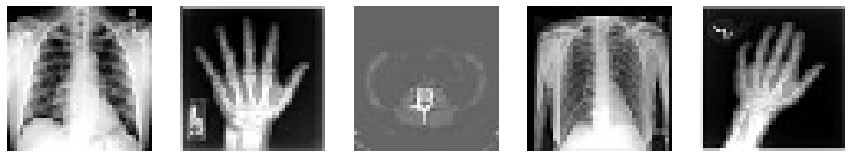

In [9]:
n_examples = 500
example_images = x_test[0:n_examples]
example_labels = y_test[0:n_examples]

f, axs = plt.subplots(1, 5, figsize=(15, 4))
for j in range(len(axs)):
    axs[j].imshow(example_images[j+42], cmap='binary')
    axs[j].axis('off')

In [10]:
x_train, y_train = next(train_generator)
x_test, y_test  = next(test_generator)
labels = [np.where(i==1)[0][0] for i in example_labels]

# Dimensionality Reduction

In [11]:
encoded_dim = 2

encoder = Sequential([
    Conv2D(input_shape=(44,44,3), filters= 64, kernel_size = (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D( (2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(encoded_dim)
])

encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 16)        4624      
_________________________________________________________________
flatten (Flatten)            (None, 1936)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3

In [12]:
pretrain_encodings = encoder(example_images).numpy()

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


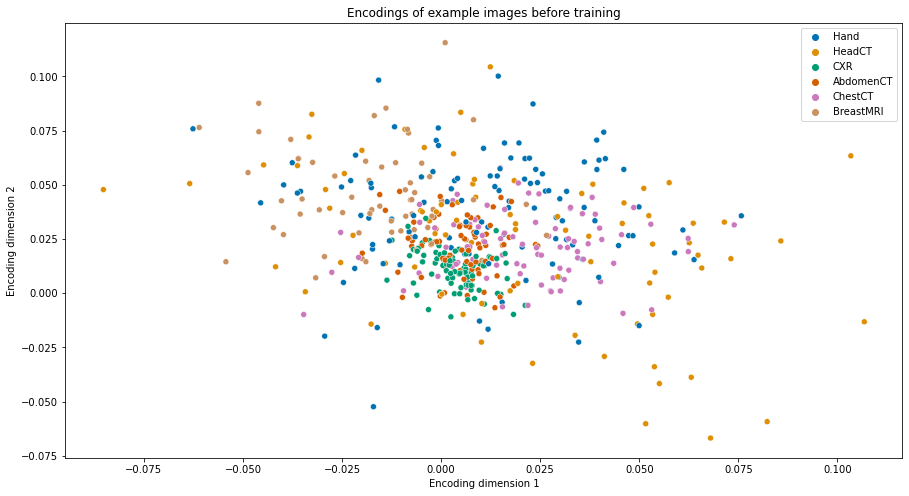

In [13]:
class_names = np.array(['AbdomenCT', 'BreastMRI', 'ChestCT','CXR','Hand','HeadCT'])
f, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.scatterplot(pretrain_encodings[:, 0],
                pretrain_encodings[:, 1],
                hue=class_names[labels], ax=ax,
                palette=sns.color_palette("colorblind", 6));
ax.set_xlabel('Encoding dimension 1'); ax.set_ylabel('Encoding dimension 2')
ax.set_title('Encodings of example images before training');

In [14]:
decoder = Sequential ([
    Dense(1936, activation = 'relu', input_shape=(encoded_dim,)),
    Reshape((11,11,16)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), padding='same') 
])

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1936)              5808      
_________________________________________________________________
reshape (Reshape)            (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 3)        

In [15]:
autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))

autoencoder_dr.compile(loss = 'mse')

autoencoder_dr.fit(x_train, x_train, epochs = 10, verbose=1)

Epoch 1/10
1474/1474 [==============================] - 235s 149ms/step - loss: 0.0423
Epoch 2/10
1474/1474 [==============================] - 238s 161ms/step - loss: 0.0232
Epoch 3/10
1474/1474 [==============================] - 234s 159ms/step - loss: 0.0213
Epoch 4/10
1474/1474 [==============================] - 221s 150ms/step - loss: 0.0204
Epoch 5/10
1474/1474 [==============================] - 229s 155ms/step - loss: 0.0198
Epoch 6/10
1474/1474 [==============================] - 221s 150ms/step - loss: 0.0197
Epoch 7/10
1474/1474 [==============================] - 221s 150ms/step - loss: 0.0193
Epoch 8/10
1474/1474 [==============================] - 224s 152ms/step - loss: 0.0191
Epoch 9/10
1474/1474 [==============================] - 225s 153ms/step - loss: 0.0189
Epoch 10/10
1474/1474 [==============================] - 225s 153ms/step - loss: 0.0190


In [16]:
posttrain_encodings = encoder(example_images).numpy()

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


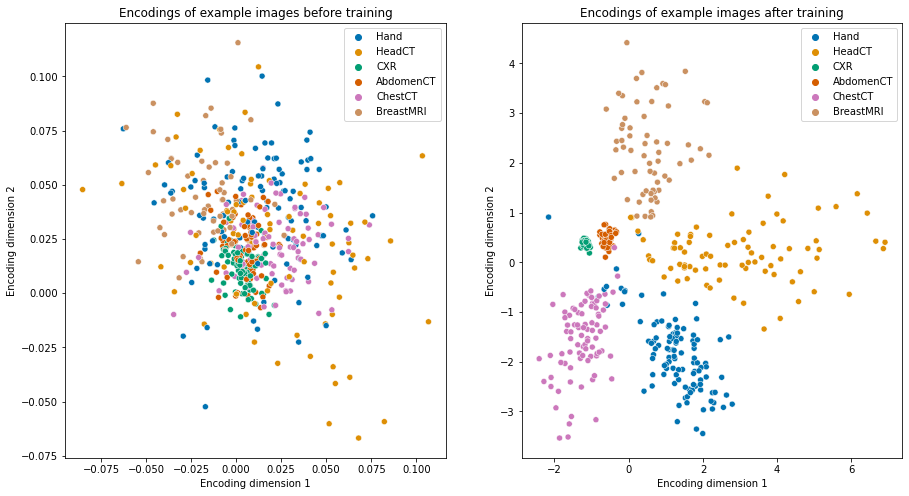

In [17]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
sns.scatterplot(pretrain_encodings[:, 0],
                pretrain_encodings[:, 1],
                hue=class_names[labels], ax=axs[0],
                palette=sns.color_palette("colorblind", 6));
sns.scatterplot(posttrain_encodings[:, 0],
                posttrain_encodings[:, 1],
                hue=class_names[labels], ax=axs[1],
                palette=sns.color_palette("colorblind", 6));

axs[0].set_title('Encodings of example images before training');
axs[1].set_title('Encodings of example images after training');

for ax in axs: 
    ax.set_xlabel('Encoding dimension 1')
    ax.set_ylabel('Encoding dimension 2')
    ax.legend(loc='upper right')

In [18]:
reconstructed_img = autoencoder_dr(example_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


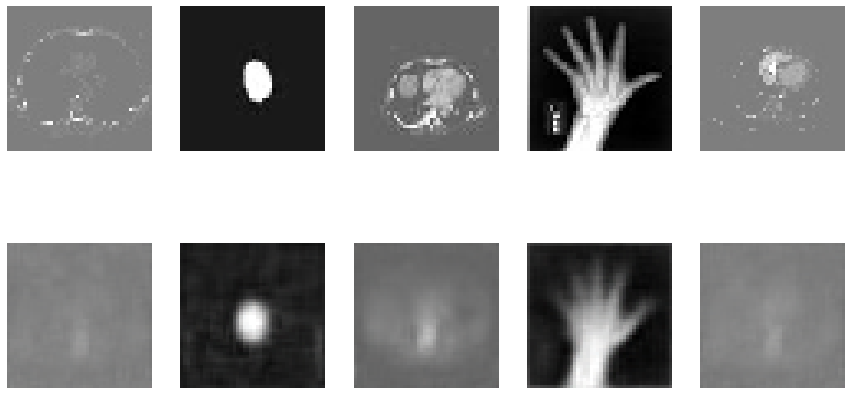

In [19]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
for j in range(5):
    axs[0, j].imshow(example_images[j+20], cmap='binary')
    axs[1, j].imshow(reconstructed_img[j+20].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

# Image Denoising

In [20]:
noise_factor = 0.2
x_train_rand = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_rand = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


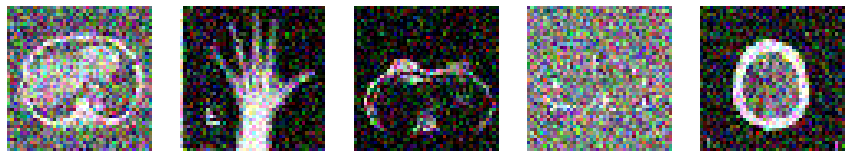

In [21]:
f, axs = plt.subplots(1, 5, figsize=(15, 8))
for j in range(len(axs)):
    axs[j].imshow(x_train_rand[j+5], cmap='binary')
    axs[j].axis('off')

In [22]:
encoder_noise = Sequential([
    
    Conv2D(input_shape = (44,44,3), filters = 256, kernel_size = (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
])

encoder_noise.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 44, 44, 256)       7168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 128)       295040    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        73792     
Total params: 376,000
Trainable params: 376,000
Non-trainable params: 0
_________________________________________________________________


In [23]:
decoder_noise = Sequential ([
    Conv2D(input_shape=(11, 11, 64), filters = 128, kernel_size=(3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

decoder_noise.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 256)       295168    
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 44, 44, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 44, 44, 3)         6915      
Total params: 375,939
Trainable params: 375,939
Non-trainable params: 0
_________________________________________________________________


In [24]:
autoencoder_noise = Model(inputs = encoder_noise.inputs, outputs = decoder_noise(encoder_noise.outputs))
autoencoder_noise.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_noise.fit(x_train_rand, x_train,
                epochs=10,
                verbose=1)

Epoch 1/10
1474/1474 [==============================] - 2166s 1s/step - loss: 0.4750
Epoch 2/10
1474/1474 [==============================] - 1045s 709ms/step - loss: 0.4563
Epoch 3/10
1474/1474 [==============================] - 1031s 699ms/step - loss: 0.4557
Epoch 4/10
1474/1474 [==============================] - 2433s 2s/step - loss: 0.4536
Epoch 5/10
1474/1474 [==============================] - 1133s 769ms/step - loss: 0.4529
Epoch 6/10
1474/1474 [==============================] - 1090s 739ms/step - loss: 0.4530
Epoch 7/10
1474/1474 [==============================] - 1014s 688ms/step - loss: 0.4530
Epoch 8/10
1474/1474 [==============================] - 1029s 698ms/step - loss: 0.4527
Epoch 9/10
1474/1474 [==============================] - 1006s 682ms/step - loss: 0.4515
Epoch 10/10
1474/1474 [==============================] - 1338s 908ms/step - loss: 0.4528


In [3]:
x_predict = autoencoder_noise.predict(x_test_rand)

In [ ]:
f, axs = plt.subplots(2, 5, figsize=(15, 8))
for j in range(5):
    axs[0, j].imshow(x_test_rand[j+13], cmap='binary')
    axs[1, j].imshow(x_predict[j+13], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')